### Import Modules

In [1]:
from luma.preprocessing.scaler import StandardScaler
from luma.reduction.linear import PCA
from luma.model_selection.split import TrainTestSplit
from luma.model_selection.search import GridSearchCV
from luma.classifier.logistic import SoftmaxRegressor
from luma.metric.classification import Accuracy
from luma.interface.util import Clone
from luma.visual.evaluation import (ConfusionMatrix,
                                    LearningCurve,
                                    ValidationCurve,
                                    ValidationHeatmap)

from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
import numpy as np

### Load Dataset

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.4)
X = lfw_people.data
y = lfw_people.target

lfw_people.images.shape, X.shape, y.shape

((1140, 50, 37), (1140, 1850), (1140,))

### Split Train and Test Sets

In [3]:
X_train, X_test, y_train, y_test = TrainTestSplit(X, y, 
                                                  test_size=0.2, 
                                                  random_state=42).get
X_train.shape, X_test.shape

((912, 1850), (228, 1850))

### Scale Through `StandardScaler`

In [4]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

### Dimensionality Reduction Through `PCA`

In [5]:
pca = PCA(n_components=150)
pca.fit(X_train)

X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

### Tuning Hyperparameters of `SoftmaxRegressor` with `GridSearchCV`

In [6]:
param_grid = {'learning_rate': np.logspace(-3, 0, 8),
              'alpha': np.logspace(-3, 0, 8)}

grid = GridSearchCV(estimator=SoftmaxRegressor(regularization='elastic-net'),
                    param_grid=param_grid,
                    cv=5,
                    refit=True,
                    random_state=42,
                    verbose=True)

grid.fit(X_train_pca, y_train)

Fitting 5 folds for 64 candidates, totalling 320 fits.

[CV] fold 1 - train-score: 0.955, test-score: 0.764
[CV] fold 2 - train-score: 0.944, test-score: 0.819
[CV] fold 3 - train-score: 0.651, test-score: 0.659
[CV] fold 4 - train-score: 0.851, test-score: 0.769
[CV] fold 5 - train-score: 0.824, test-score: 0.712
[GridSearchCV] candidate 1/64 {'learning_rate': 0.001, 'alpha': 0.001} - score: 0.745
[CV] fold 1 - train-score: 0.948, test-score: 0.824
[CV] fold 2 - train-score: 0.941, test-score: 0.841
[CV] fold 3 - train-score: 0.823, test-score: 0.692
[CV] fold 4 - train-score: 0.893, test-score: 0.769
[CV] fold 5 - train-score: 0.714, test-score: 0.630
[GridSearchCV] candidate 2/64 {'learning_rate': 0.001, 'alpha': 0.0026826957952797246} - score: 0.751
[CV] fold 1 - train-score: 0.940, test-score: 0.819
[CV] fold 2 - train-score: 0.945, test-score: 0.802
[CV] fold 3 - train-score: 0.960, test-score: 0.841
[CV] fold 4 - train-score: 0.953, test-score: 0.830
[CV] fold 5 - train-score: 0

### Extract Best Model

In [7]:
model = grid.best_model
grid.best_params, grid.best_score

({'learning_rate': 0.3727593720314938, 'alpha': 0.0026826957952797246},
 0.8278069756330627)

### Evaluate Model

#### 1. Learning Curve

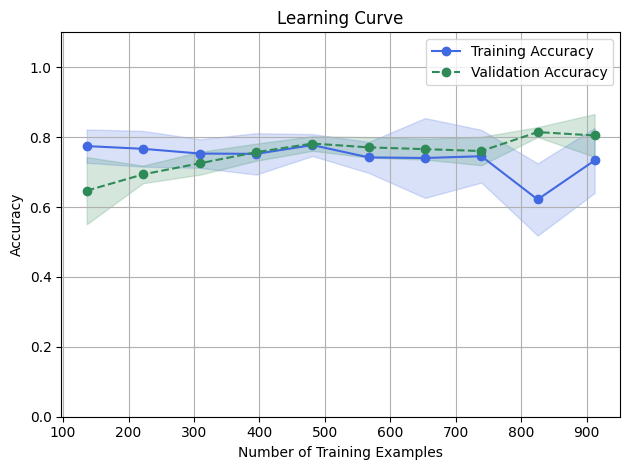

<Axes: title={'center': 'Learning Curve'}, xlabel='Number of Training Examples', ylabel='Accuracy'>

In [8]:
lr_curve = LearningCurve(estimator=Clone(model, False).get,
                         X=X_train_pca,
                         y=y_train,
                         train_sizes=np.linspace(0.15, 1.0, 10),
                         test_size=0.3,
                         cv=5,
                         metric=Accuracy,
                         random_state=42)

lr_curve.plot(show=True)

#### 2. Validation Curves for `learning_rate` and `alpha`

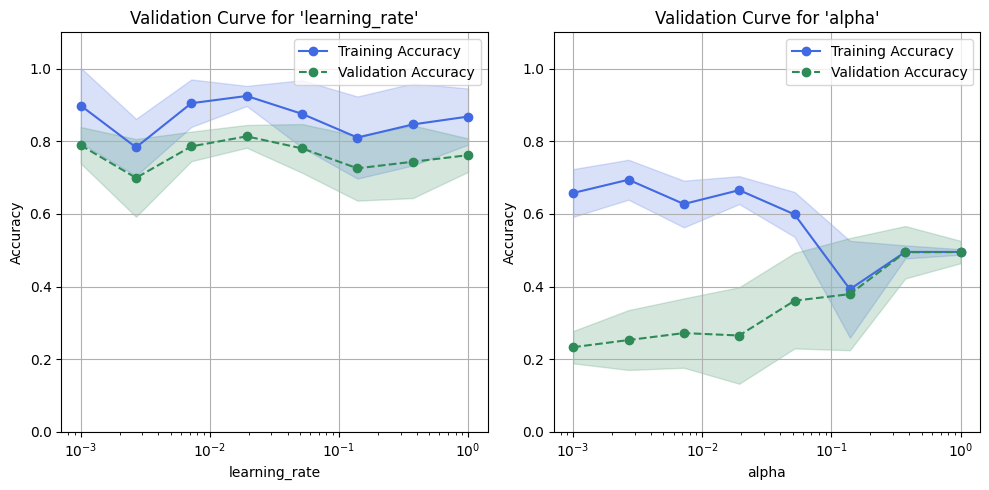

<Axes: title={'center': "Validation Curve for 'alpha'"}, xlabel='alpha', ylabel='Accuracy'>

In [18]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

val_curve_C = ValidationCurve(estimator=Clone(model, False).get,
                              X=X_train_pca,
                              y=y_train,
                              param_name='learning_rate',
                              param_range=param_grid['learning_rate'],
                              cv=5,
                              metric=Accuracy,
                              random_state=42)

val_curve_gamma = ValidationCurve(estimator=Clone(model, False).get,
                                  X=X_test_pca,
                                  y=y_train,
                                  param_name='alpha',
                                  param_range=param_grid['alpha'],
                                  cv=5,
                                  metric=Accuracy,
                                  random_state=42)

val_curve_C.plot(ax1, xscale='log')
val_curve_gamma.plot(ax2, xscale='log', show=True)

#### 3. Validation Heatmap between `learning_rate` and `alpha`

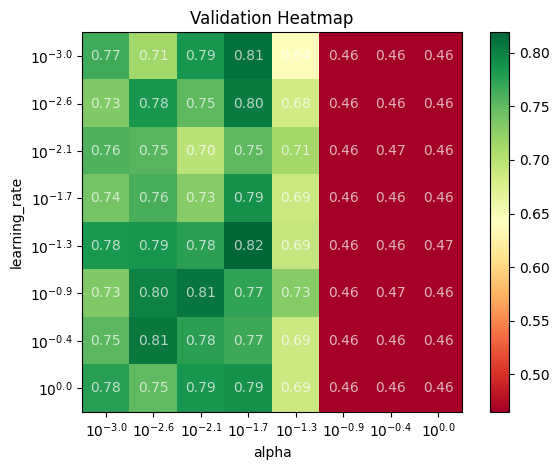

<Axes: title={'center': 'Validation Heatmap'}, xlabel='alpha', ylabel='learning_rate'>

In [19]:
val_hmap = ValidationHeatmap(estimator=Clone(model, False).get,
                             X=X_train_pca,
                             y=y_train,
                             param_dict=param_grid,
                             cv=5,
                             metric=Accuracy,
                             random_state=42)

val_hmap.plot(show=True)

#### 4. Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix of Test Set')

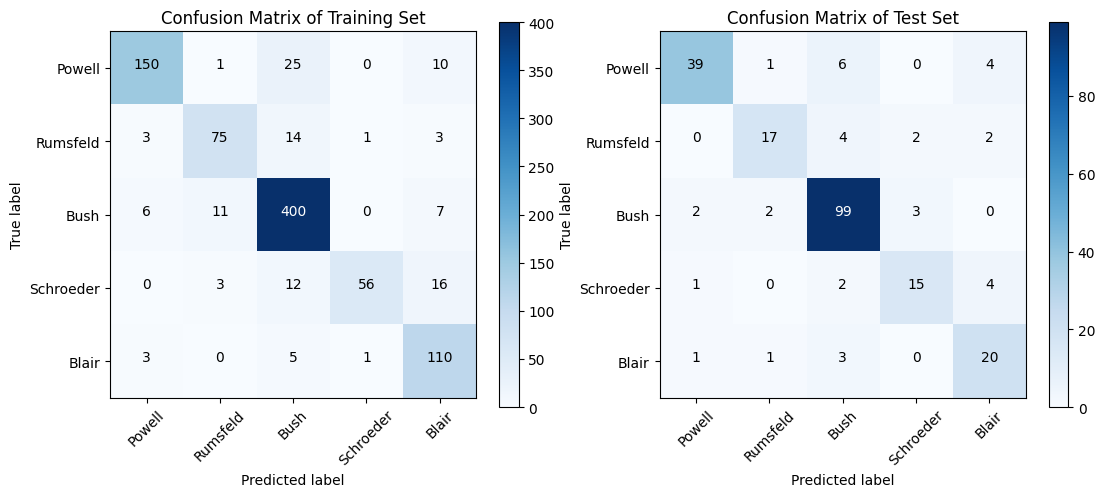

In [29]:
fig = plt.figure(figsize=(13, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

last_names = [name.rsplit(' ')[-1] for name in lfw_people.target_names]

conf_train = ConfusionMatrix(y_true=y_train, 
                             y_pred=model.predict(X_train_pca),
                             labels=last_names)

conf_test = ConfusionMatrix(y_true=y_test, 
                            y_pred=model.predict(X_test_pca),
                            labels=last_names)

conf_train.plot(ax1)
conf_test.plot(ax2)

ax1.set_title('Confusion Matrix of Training Set')
ax2.set_title('Confusion Matrix of Test Set')

#### 5. Actual Prediction Comparison

In [30]:
def plot_gallery(images, titles, h, w, n_row, n_col):
    plt.figure(figsize=(1.5 * n_col, 2 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
    plt.tight_layout()
    plt.show()

In [31]:
def get_title(pred, true, names, i):
    pred_name = names[pred[i]].rsplit(' ', 1)[-1]
    true_name = names[true[i]].rsplit(' ', 1)[-1]
    return 'pred: %s\ntrue: %s' % (pred_name, true_name)

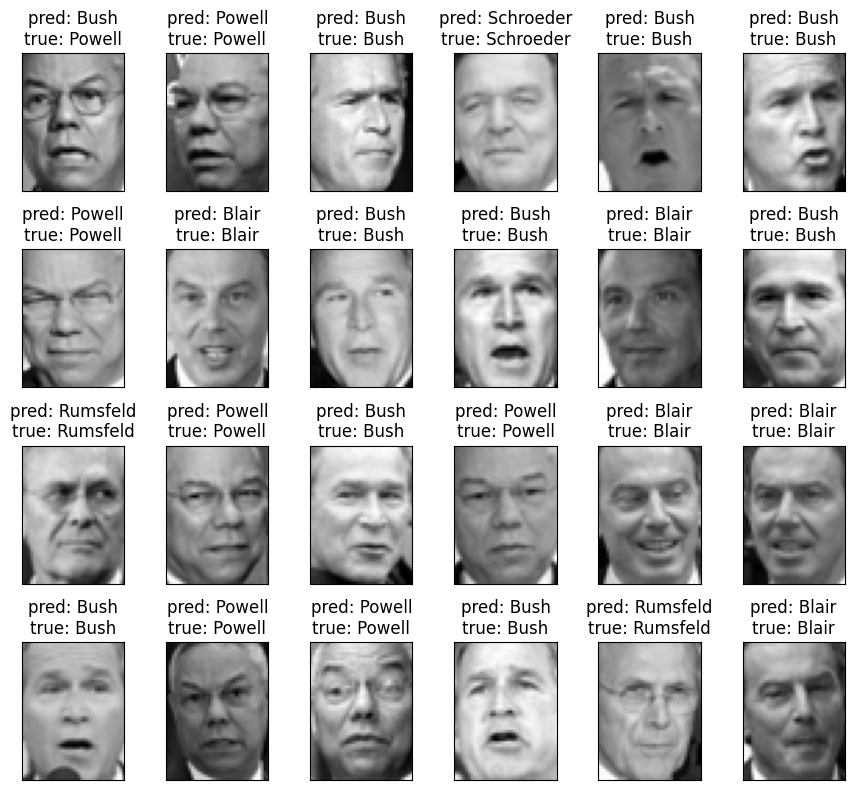

In [32]:
test_pred = model.predict(X_test_pca)
titles = [
    get_title(test_pred, y_test, lfw_people.target_names, i) 
    for i in range(y_test.shape[0])
]

plot_gallery(X_test, titles, *lfw_people.images.shape[1:], 4, 6)